In [1]:
import numpy as np
import matplotlib.pyplot as plt
import abtem
import ase

## Build atomic potential

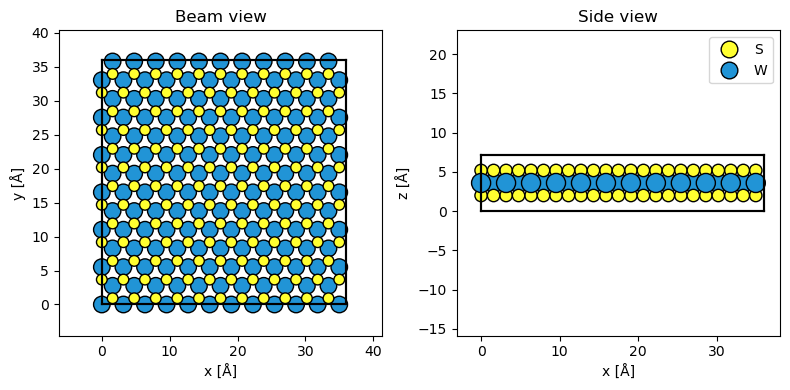

In [2]:
atoms = ase.build.mx2("WS2", vacuum=2)
atoms = abtem.orthogonalize_cell(atoms) * (14, 8, 1)
new_atoms = abtem.atoms.cut_cell(atoms, cell=[36, 36, 7.1899999999999995]) # crop to a square model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(new_atoms, ax=ax1, title="Beam view")
abtem.show_atoms(new_atoms, plane="xz", ax=ax2, title="Side view", legend=True)
fig.tight_layout()

[########################################] | 100% Completed | 325.78 ms


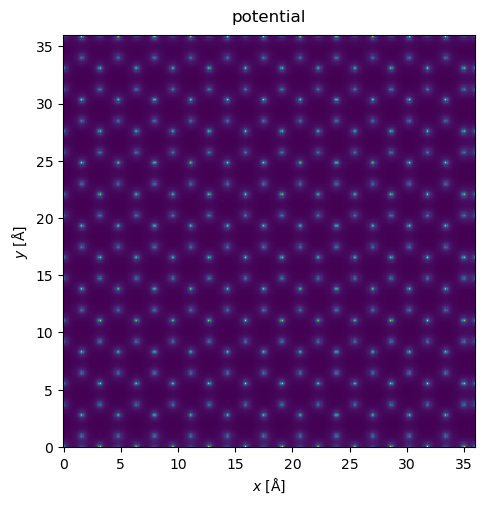

In [3]:
potential = abtem.Potential(
    new_atoms,
    sampling=0.1,
    device="cpu",
    projection="infinite",
    parametrization="kirkland",
)

potential.project().show(cmap='viridis', title="potential")

## Initialize probe

[########################################] | 100% Completed | 106.53 ms


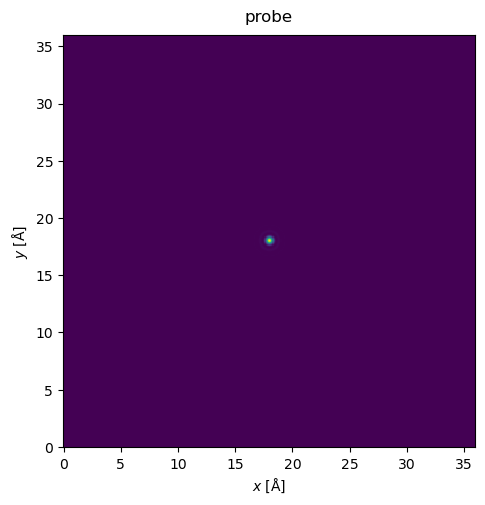

In [4]:
energy = 200e3 # voltages
semiangle_cutoff = 25 # mrad
defocus = 0 # angstrom
#aberrations = {"C10": -defocus, 
               # "C12": 8, "phi12": -0.5, 
               # "C21": 50, "phi21": 0.1,
              #  "C23": 50, "phi23": 0.4,
              #  "C30": 1e5, 
              #  "C32": 2e4, "phi32": 0.9,
              #  "C34": 2e4, "phi34": 0.4,
              # }
aberrations = {"C10": -defocus, 
               "C12": 0, "phi12": -0.5, 
               "C21": 0, "phi21": 0.1,
               "C23": 0, "phi23": 0.4,
               "C30": 0e5, 
               "C32": 0e4, "phi32": 0.9,
               "C34": 0e4, "phi34": 0.4,
              }

probe = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
    **aberrations,
    device="cpu",
)

probe.match_grid(potential)

probe.show(cmap='viridis', title="probe")

## Grid scan simulation

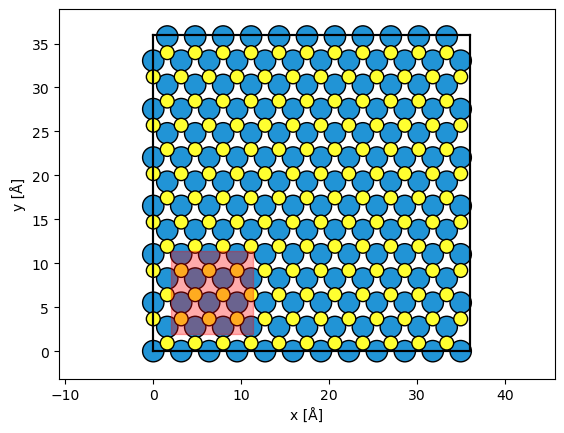

In [5]:
maximum_scattering_angle_mrad = 75 # mrad
scan_step_size = 0.24 # angstrom
scan_pixels = 39
scan_start = [2, 2]
scan_end = [scan_start[0] + scan_step_size*scan_pixels, scan_start[1] + scan_step_size*scan_pixels]

pixelated_detector = abtem.PixelatedDetector(max_angle=maximum_scattering_angle_mrad)

gridscan = abtem.GridScan(
    start=scan_start, 
    end=scan_end,
    # fractional=True,
    potential=potential,
    sampling=scan_step_size,
)

fig, ax = abtem.show_atoms(new_atoms)
gridscan.add_to_plot(ax)

[########################################] | 100% Completed | 5.49 ss


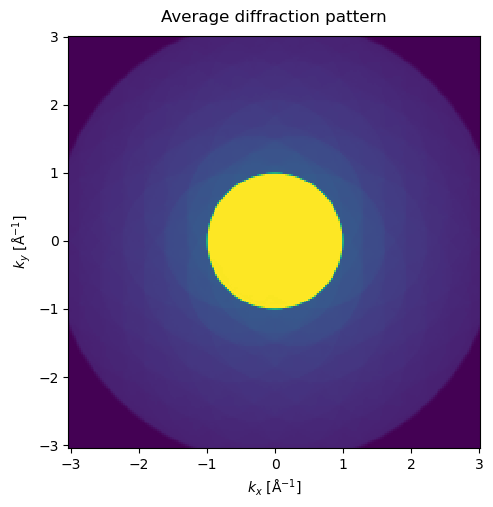

In [6]:
# Simulation
diffraction_patterns = probe.scan(potential, 
                                  scan=gridscan, 
                                  detectors=pixelated_detector,
                                  )
diffraction_patterns.compute()
diffraction_patterns.mean((0,1)).show(power=0.25, title='Average diffraction pattern', cmap='viridis')

In [7]:
# Saving dataset
data_dict = {
    'data_4D': np.float32(diffraction_patterns.array),
    'scan_step_size': scan_step_size,
    'aperture_size': semiangle_cutoff/1e3,
    'voltage': energy/1e3,
    'dose': 'infinity'
}
filename = f'WS2bilayer_75mradcut_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_noise_free.npy'
np.save(filename, data_dict)

## Apply Poisson noise

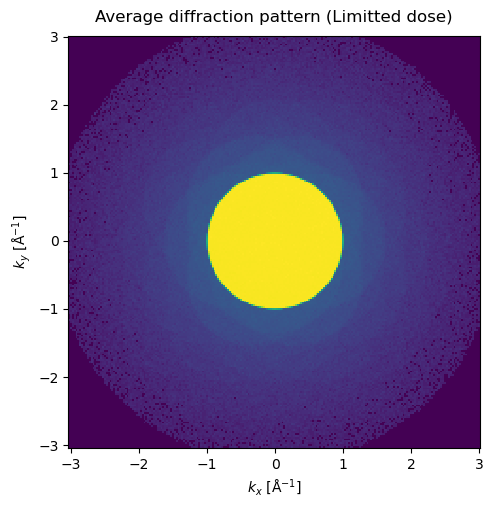

In [8]:
# Apply poisson noise
dose = 1e4 # electrons per square angstrom
dose = 1e6 # electrons per square angstrom
measurement_noise = diffraction_patterns.poisson_noise(dose)
measurement_noise.mean((0,1)).show(power=0.25, 
                                   title='Average diffraction pattern (Limitted dose)', 
                                   cmap='viridis')
data_4D = measurement_noise.array

In [9]:
print(f'dataset size:\t {data_4D.shape}')
print(f'scan step size:\t {scan_step_size} A')
print(f'aperture size:\t {int(semiangle_cutoff)} mrad')
print(f'voltage:\t {int(energy/1000)} keV')
print(f'dose:\t\t {int(dose)} e/A^2')

dataset size:	 (39, 39, 218, 218)
scan step size:	 0.24 A
aperture size:	 25 mrad
voltage:	 200 keV
dose:		 1000000 e/A^2


In [10]:
# Saving dataset
data_dict = {
    'data_4D': np.float32(measurement_noise.array),
    'scan_step_size': scan_step_size,
    'aperture_size': semiangle_cutoff/1e3,
    'voltage': energy/1e3,
    'dose': dose
}
filename = f'WS2bilayer_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_dose_{int(dose)}.npy'
filename = f'WS2bilayer_current.npy'
np.save(filename, data_dict)

# Single side-band (SSB) ptychography reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
#sys.path.append('/Users/test/repos/pyptychostem/') # path to pyptychostem
sys.path.append('./Songge_1/') # path to pyptychostem
from STEM4D import *
%matplotlib widget

## Load dataset and set parameters

In [2]:
#filename = '../WS2_200kV_25mrad_noise_free.npy'
#filename = 'WS2bilayer36_200kV_25mrad_noise_free.npy'
#filename = f'WS2bilayer_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_dose_{int(dose)}.npy'
filename = f'WS2bilayer_current.npy'
data = np.load(filename, allow_pickle=True).item()
parfile = {'aperture': data['aperture_size'], 
           'voltage': data['voltage'], 
           'stepsize': data['scan_step_size'], 
           'threshold': 0.2}
data_4D = Data4D(parfile, data=data['data_4D'])
data_4D.bin_Q(bin_factor=2)
data_4D.estimate_aperture_size()
data_4D.plot_4D()

{'aperture': 0.025, 'voltage': 200.0, 'stepsize': 0.24, 'threshold': 0.2}
dataset size:	 (39, 39, 109, 109)


<Signal2D, title: 4D data, dimensions: (39, 39|109, 109)>

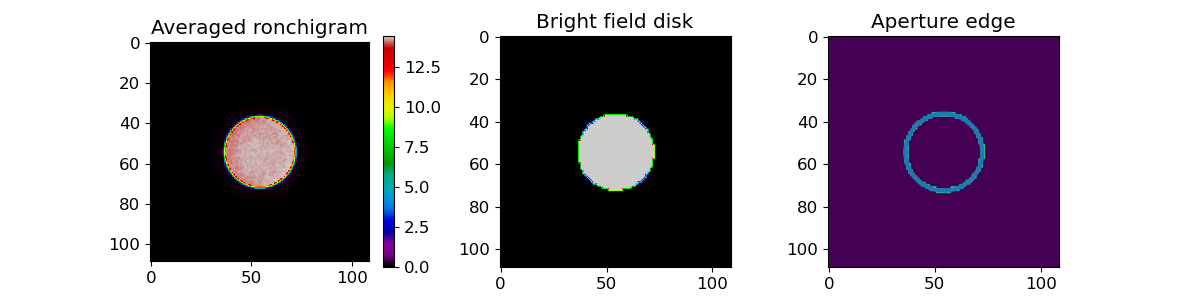

In [3]:
data_4D.plot_aperture()


## Fourier transform 4D dataset in scanning space $G(\mathbf{K_f, Q})=\mathcal{F}_{\mathbf{r}}\{I(\mathbf{K_f, r})\}$

In [4]:
data_4D.truncate_ronchigram(expansion_ratio=None) # crops ronchigram to the BF disk
data_4D.apply_FT()


In [5]:
data_4D.plot_4D_reciprocal(signal='amplitude')

<Signal2D, title: FT of 4D data, dimensions: (39, 39|109, 109)>

In [6]:
data_4D.plot_4D_reciprocal_both()

The module://ipympl.backend_nbagg matplotlib backend is not compatible with the traitsui GUI elements. For more information, read http://hyperspy.readthedocs.io/en/stable/user_guide/getting_started.html#possible-warnings-when-importing-hyperspy.


<Signal2D, title: FT of 4D data, dimensions: (39, 39, 2|109, 109)>

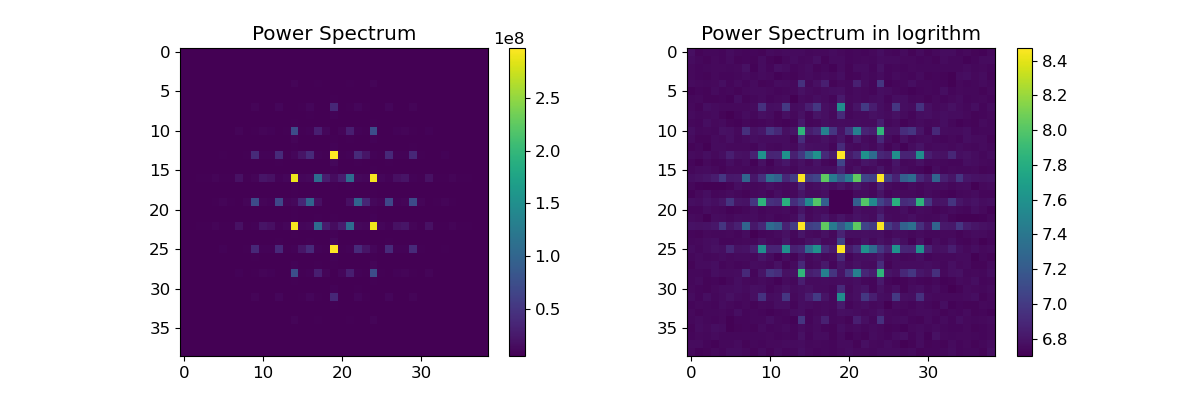

In [7]:
data_4D.remove_zero_frequency()
data_4D.plot_FT()

## Reconstruct without aberration correction

In [8]:
plt.close('all')
%matplotlib inline

In [9]:
ssb = SSB(data_4D)
ssb.run()

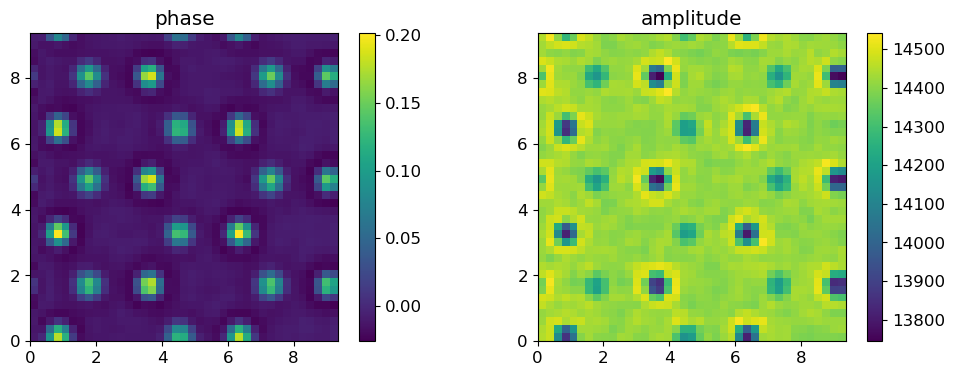

In [10]:
ssb.plot_result()

## Aberration correction

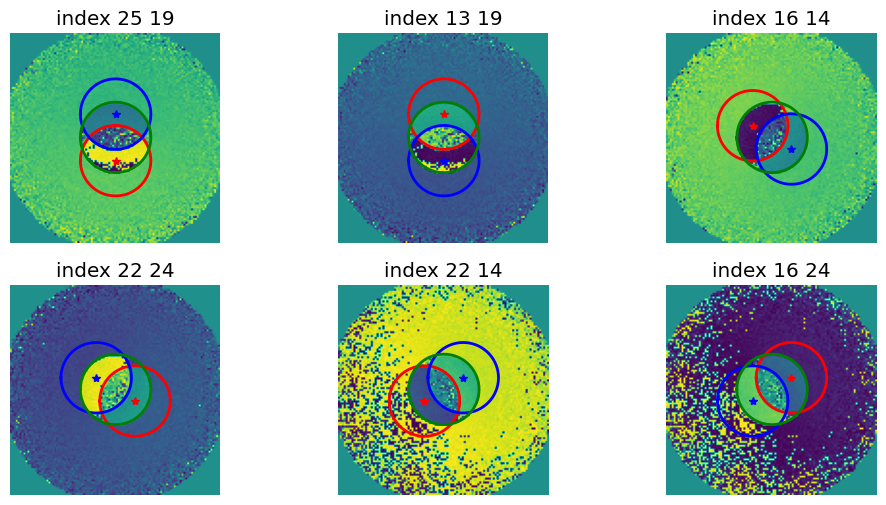

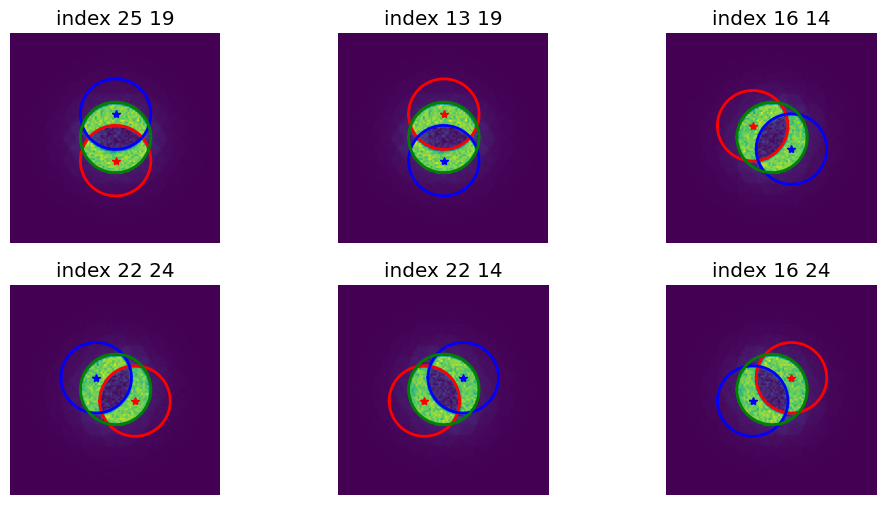

In [30]:
#data_4D.plot_trotters(rotation_angle=0,skip=1)
data_4D.plot_trotters()

In [31]:
svd = SVD_AC(data_4D, trotters_nb=6)
svd.find_trotters()

6 trotters found
trotter index: [[25, 19], [13, 19], [16, 14], [22, 24], [22, 14], [16, 24]]


In [32]:
aberration_coeffs = svd.run_svd(iterations=20, order=3, cf=0.5)
svd.print_aberration_coefficients(aberration_coeffs)

C10  =  0.576  nm
C12a =  0.036  nm
C12b =  0.077  nm
C21a =  14.178  nm
C21b =  4.743  nm
C23a =  -0.159  nm
C23b =  -0.488  nm
C30  =  -0.79  um
C32a =  -0.171  um
C32b =  -0.352  um
C34a =  -0.093  um
C34b =  -0.032  um
C41a =  0.0  mm
C41b =  0.0  mm
C43a =  0.0  mm
C43b =  0.0  mm
C45a =  0.0  mm
C45b =  0.0  mm
C50  =  0.0  mm
C52a =  0.0  mm
C52b =  0.0  mm
C54a =  0.0  mm
C54b =  0.0  mm
C56a =  0.0  mm
C56b =  0.0  mm


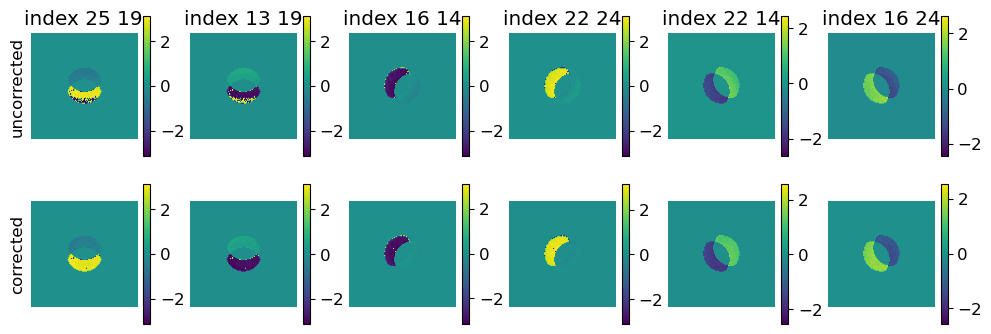

In [33]:
svd.plot_corrected_trotters(data_4D.selected_frames,svd.aberration_coeffs)

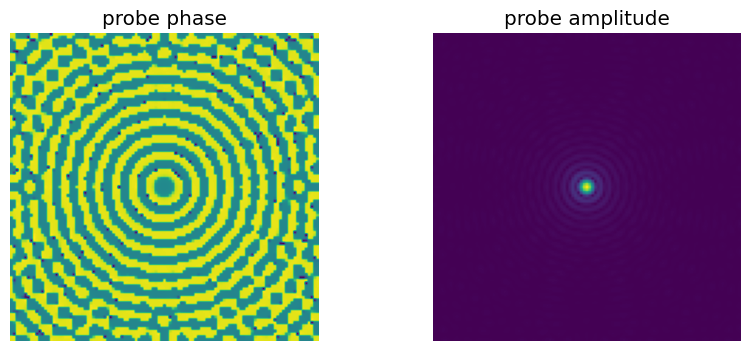

In [34]:
svd.calc_probefunction()
svd.plot_probe()

## Reconstruct after aberrations correction

In [35]:
ssb_ac = SSB(data_4D)
ssb_ac.run(aberrations=svd.aberration_coeffs, order=3)

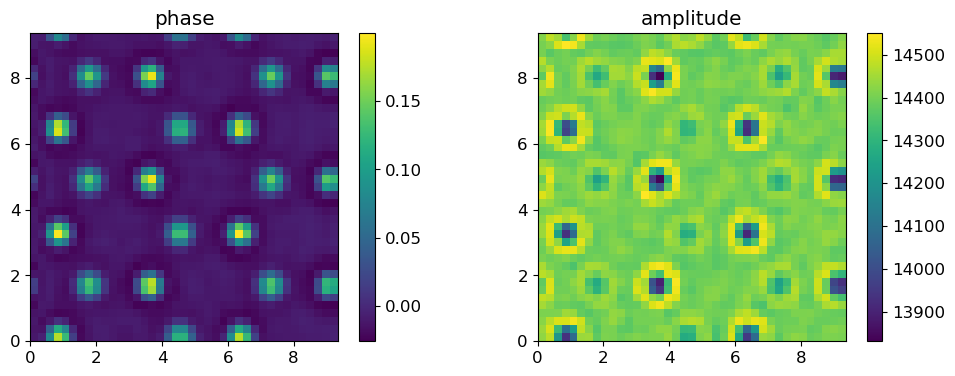

In [36]:
ssb_ac.plot_result()

# Iterative ptychography

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./Songge_1/') # path to pyptychostem
from PIE_utils import *
%matplotlib inline

## Load dataset and set parameters

In [12]:
# Import data
bin_factor = 2
#filename = '../WS2_200kV_25mrad_dose 10000.npy'
#filename = f'WS2bilayer_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_dose_{int(dose)}.npy'
filename = f'WS2bilayer_current.npy'
data = np.load(filename, allow_pickle=True).item()
data_4D = data['data_4D']
scan_step_size = data['scan_step_size']
aperture_size = data['aperture_size']
voltage = data['voltage']

# iteration parameters
beta_obj, beta_probe = [0.05,0.02] # iterative step for object and probe
iterations = 40
iter_parameters = (beta_obj, beta_probe, iterations)

# bin dataset
data_4D = bin_Q(data_4D, bin_factor)

print(f"dataset size:\t {data_4D.shape, data_4D.dtype}")
print(f"scan step size:\t {scan_step_size} A")
print(f"aperture size:\t {aperture_size} rad")
print(f"voltage:\t {int(voltage)} keV")
#print(f"dose:\t\t {int(data['dose'])} e/A^2")

dataset size:	 ((39, 39, 109, 109), dtype('float32'))
scan step size:	 0.24 A
aperture size:	 0.025 rad
voltage:	 200 keV


In [13]:
print(f"dose:\t\t {int(data['dose'])} e/A^2")

dose:		 1000000 e/A^2


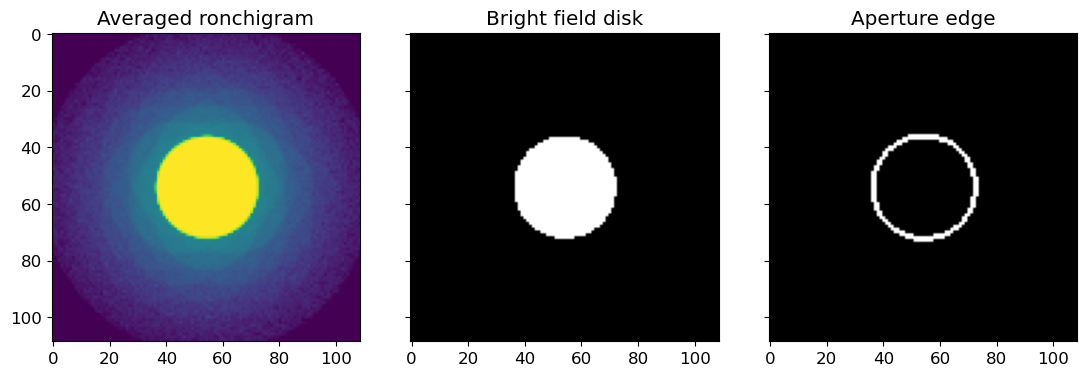

In [14]:
# set parameters for scanning and Ronchigram
wave_len = Wavelength(voltage)
scan_angles_x, scan_angles_y = set_scan(data_4D, scan_step_size, wave_len)
Ronchi_norm, BFdisk, edge, center_x, center_y, calibration, Ronchi_angles = calibrate_ronchi(data_4D, aperture_size)

## ePIE based on random guesses

### Preprocess for a random guess

Flattened diffraction patterns shape: (1521, 109, 109)


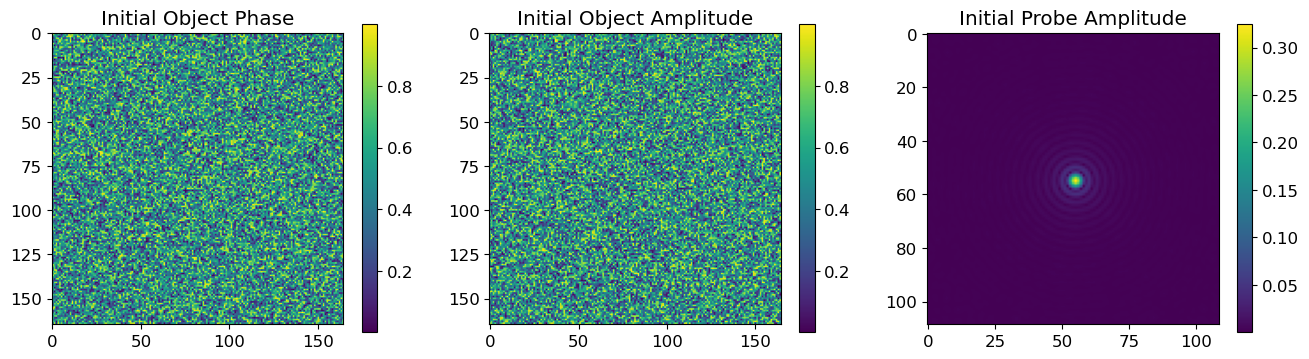

In [15]:
(phase_min_guess, phase_max_guess) = (0,1)

diff_patts, obj_init, probe_init, probe_range_series, scan_area = preprocess(data_4D, scan_step_size, aperture_size, 
                                                                             calibration, Ronchi_angles, wave_len, 
                                                                             iterations, (phase_min_guess, phase_max_guess))

### Run ePIE

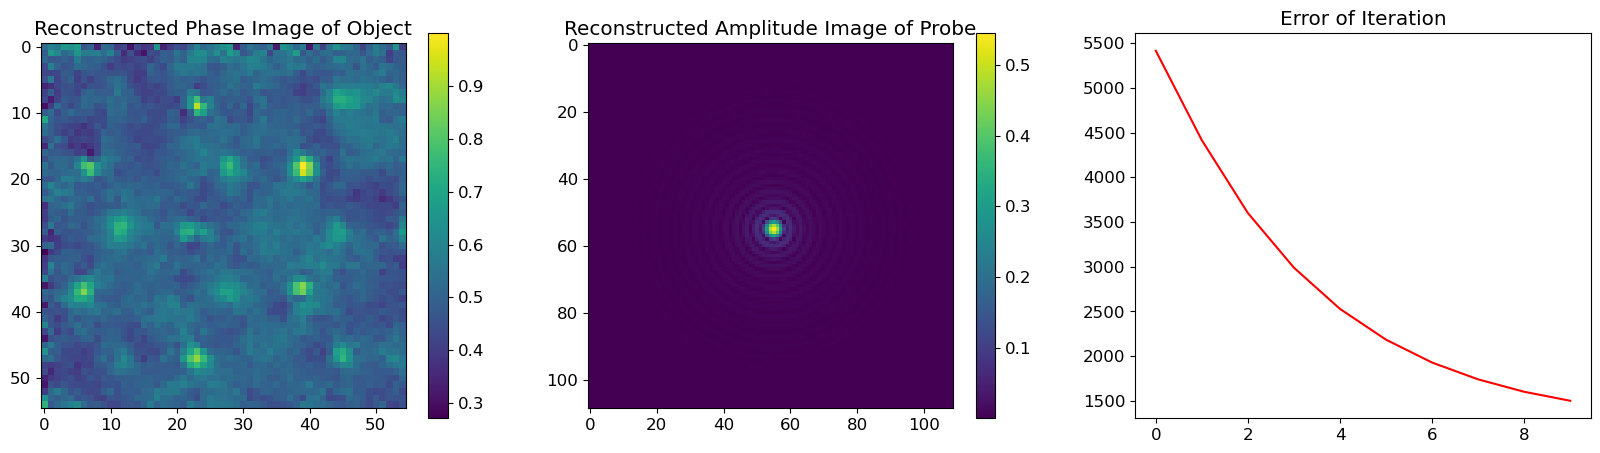

In [16]:
iterations = 10
iter_parameters = (beta_obj, beta_probe, iterations)
obj, probe, error, obj_series = run_ePIE(diff_patts, obj_init, probe_init, iter_parameters, probe_range_series, scan_area)

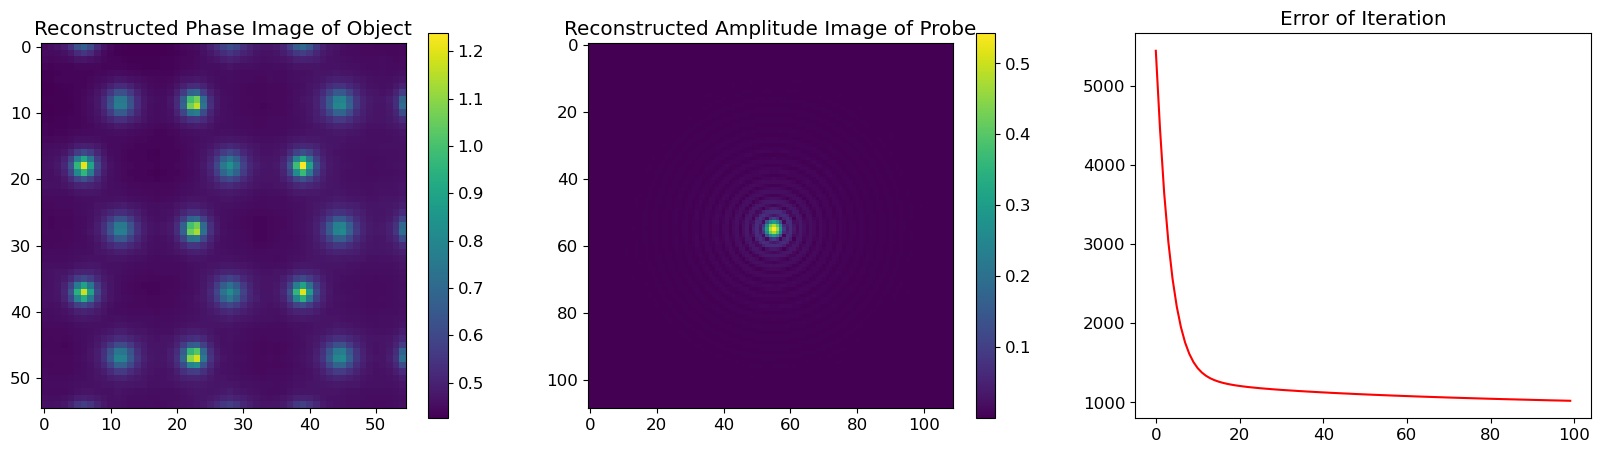

In [26]:
iterations = 100
iter_parameters = (beta_obj, beta_probe, iterations)
obj, probe, error, obj_series = run_ePIE(diff_patts, obj_init, probe_init, iter_parameters, probe_range_series, scan_area)

## WASP based on random guesses

### Preprocess for a random guess

Flattened diffraction patterns shape: (1521, 109, 109)


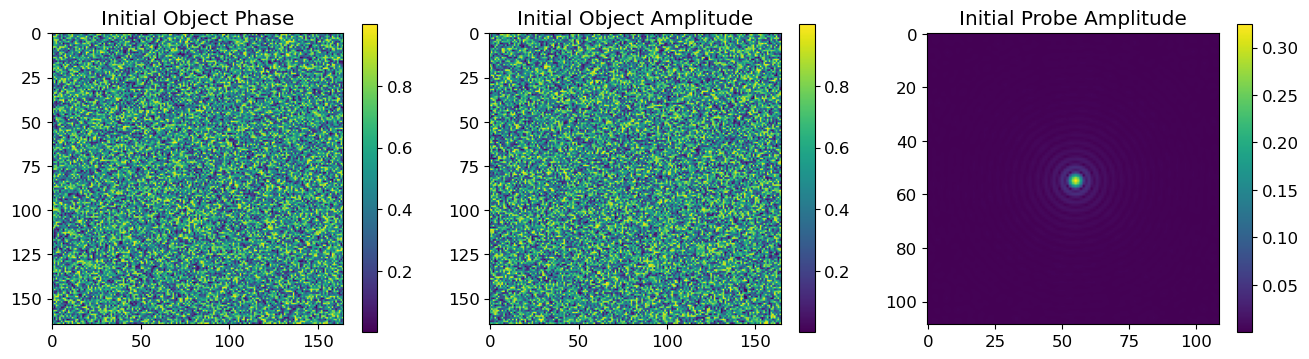

In [17]:
(phase_min_guess, phase_max_guess) = (0,1)

diff_patts, obj_init, probe_init, probe_range_series, scan_area = preprocess(data_4D, scan_step_size, aperture_size, 
                                                                             calibration, Ronchi_angles, wave_len, 
                                                                             iterations, (phase_min_guess, phase_max_guess))

### Run WASP

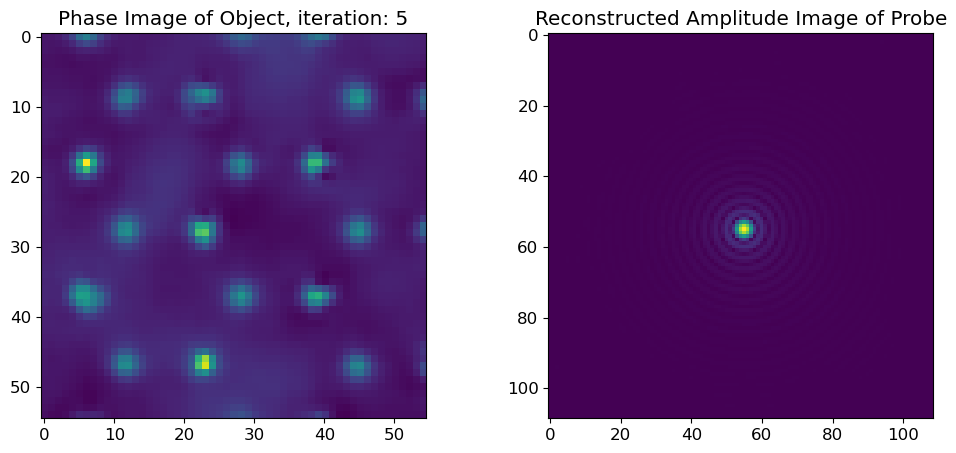

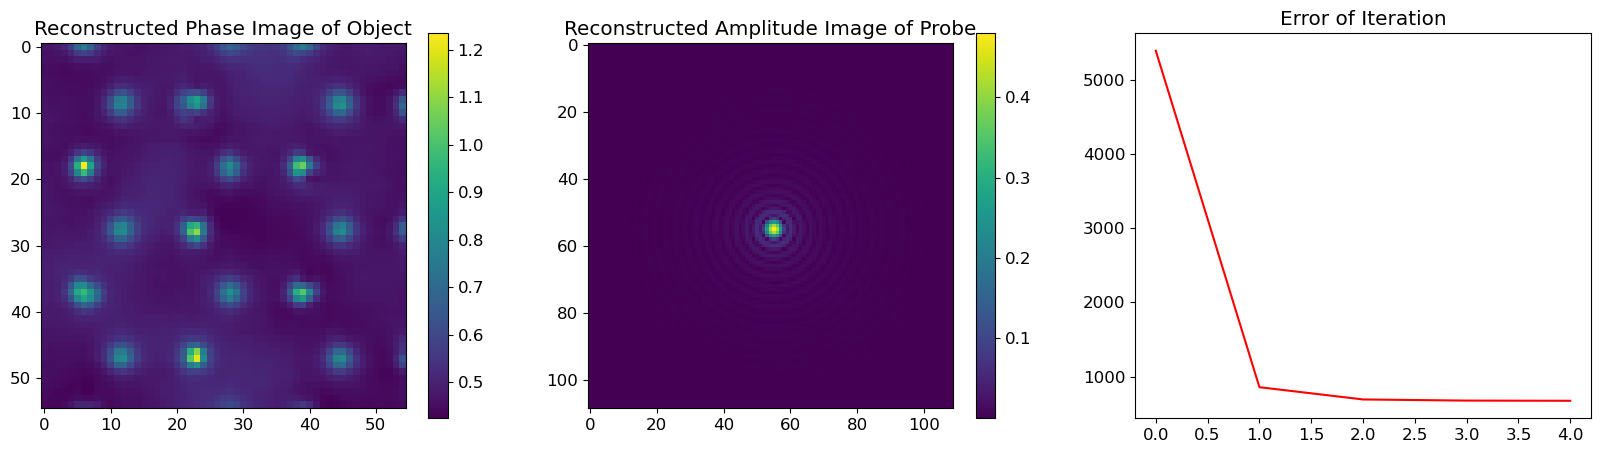

In [18]:
iterations = 5
iter_parameters = (beta_obj, beta_probe, iterations)
obj, probe, error, obj_series = run_WASP(diff_patts, obj_init, probe_init, iter_parameters, probe_range_series, scan_area)

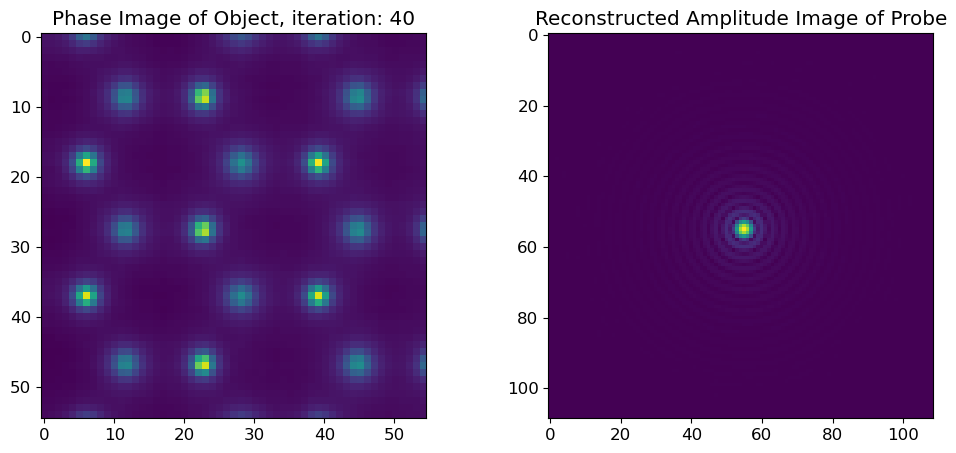

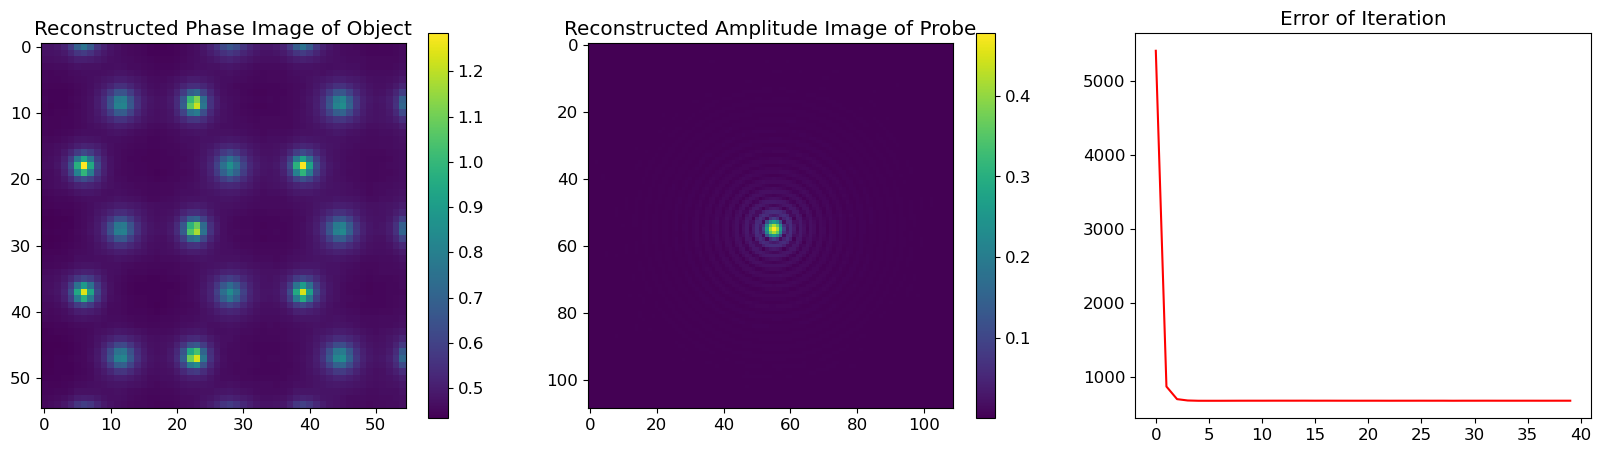

In [47]:
iterations = 40
iter_parameters = (beta_obj, beta_probe, iterations)
obj, probe, error, obj_series = run_WASP(diff_patts, obj_init, probe_init, iter_parameters, probe_range_series, scan_area)

## resolution

In [58]:
print('wavelength is ',probe.wavelength)
print('convergence is',probe.semiangle_cutoff, 'mrad')
print('2 alpha/lambda ', probe.wavelength/(2*(probe.semiangle_cutoff/1000)),'Å resolution limit')
print('max scattering/lambda ', probe.wavelength/(2*(maximum_scattering_angle_mrad/1000)),'Å resolution limit')

wavelength is  0.025079340317328468
convergence is 25 mrad
2 alpha/lambda  0.5015868063465693 Å resolution limit
max scattering/lambda  0.16719560211552312 Å resolution limit
